## 5.2 Stable Diffusion and DreamBooth
 Stable diffusion is a latent text-to-image diffusion model capable of generating photo-realistic images given any text input.

 We use `runwayml/stable-diffusion-v1-5` in this notebook. 

Use the pre-downloaded model weights on `/share/lab5/sd`, or make sure you have downloaded the weights of stable-diffusion: 


### Stable Diffusion Model

In [1]:
# You can directly use the downloaded weights from /share/lab5/sd, or pre-download them:

#!export HF_ENDPOINT=https://hf-mirror.com
#!huggingface-cli download --resume-download runwayml/stable-diffusion-v1-5  --local-dir your_path_of_sd

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

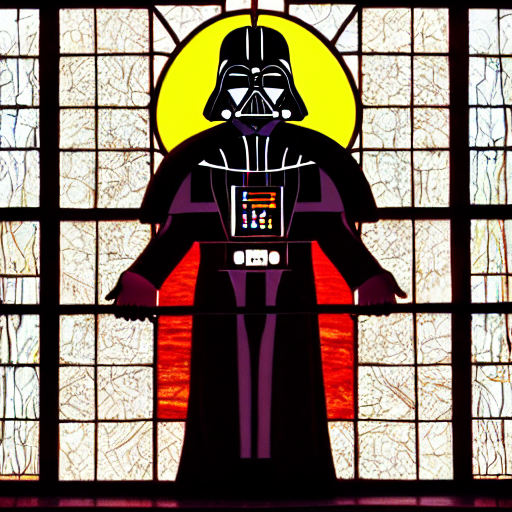

In [2]:
#If you encounter an 'out of memory' error, make sure no other programs are running on this GPU (reset the previous notebook's kernel).

from diffusers import AutoPipelineForText2Image
import torch
pipeline = AutoPipelineForText2Image.from_pretrained("/share/lab5/sd", torch_dtype=torch.float16, variant="fp16").to("cuda")
output = pipeline("stained glass of darth vader, backlight, centered composition, masterpiece, photorealistic, 8k")

for image in output.images:
    image.show()


In [3]:
# using stable diffusion in Image2Image pipeline  (just change the AutoPipeline class)

from diffusers import AutoPipelineForImage2Image
import torch
import requests
from PIL import Image
from io import BytesIO

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "/share/lab5/sd",
    torch_dtype=torch.float16,
    use_safetensors=True,
).to("cuda")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

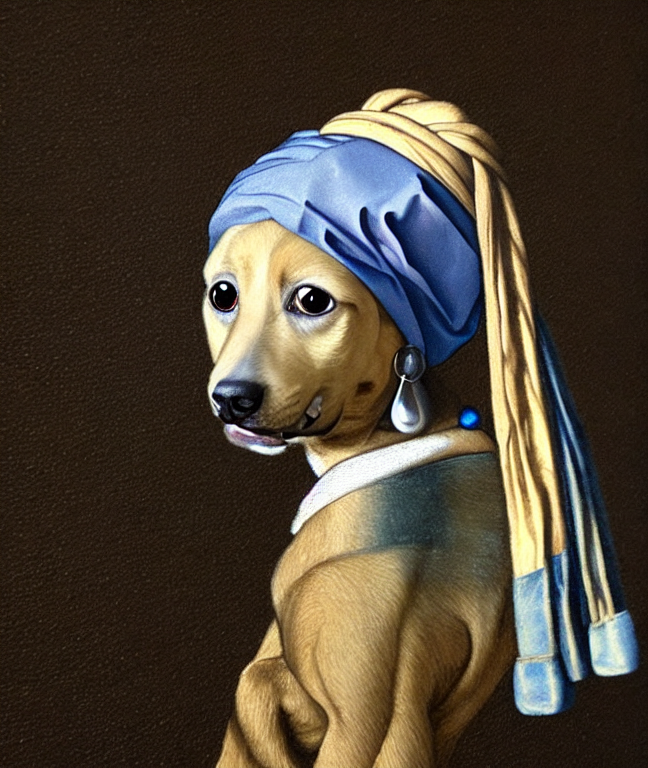

In [4]:
# the image to image pipeline requires inputting an image.

image = Image.open("/share/lab5/data/Girl_with_a_Pearl_Earring.jpg").convert("RGB")
prompt = "a portrait of a dog wearing a pearl earring"
image.thumbnail((768, 768))

image = pipeline(prompt, image, num_inference_steps=200, strength=0.75, guidance_scale=10.5).images[0]
image

### [Do it after class, as it will take a while] Stable-diffusion with Dreambooth
DreamBooth is a training technique that updates the entire diffusion model by training on just a few images of a subject or style. It works by associating a special word in the prompt with the example images.

- If you’re training on a GPU with limited vRAM, you should try enabling the `gradient_checkpointing` and  `mixed_precision` parameters in the training command. 

- The script also allows to fine-tune the `text_encoder` along with the `unet`. It's been observed experimentally that fine-tuning `text_encoder` gives much better results especially on faces. 
Pass the `--train_text_encoder` argument to the script to enable training `text_encoder`.

First, we need to finetune the diffusion model.

I strongly suggest you reset your kernel here to prevent it from out of memory.

In [2]:
# a few directory settings

MODEL_NAME="/share/lab5/sd"
INSTANCE_DIR="/share/lab5/data/dog" 
CLASS_DIR='/scratch2/original_dog' 
MODEL_OUTPUT="/scratch2/dog-model"

INSTANCE_PROMPT='a photo of sks dog'
CLASS_PROMPT="a photo of a dog"

In [3]:
# run the training script (this will take a long while)

!python train_dreambooth.py \
  --pretrained_model_name_or_path={MODEL_NAME} \
  --instance_data_dir={INSTANCE_DIR} \
  --class_data_dir={CLASS_DIR} \
  --output_dir={MODEL_OUTPUT} \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="{INSTANCE_PROMPT}"\
  --class_prompt="{CLASS_PROMPT}" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --max_train_steps=800 \
  --gradient_checkpointing \
  --mixed_precision fp16

04/22/2024 14:14:13 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'image_encoder', 'requires_safety_checker'} was not found in config. Values will be initialized to default values.
Loading pipeline components...:   0%|                     | 0/6 [00:00<?, ?it/s]{'conv_out_kernel', 'time_embedding_act_fn', 'dropout', 'reverse_transformer_layers_per_block', 'time_embedding_type', 'transformer_layers_per_block', 'time_cond_proj_dim', 'class_embeddings_concat', 'dual_cross_attention', 'addition_time_embed_dim', 'mid_block_type', 'resnet_out_scale_factor', 'class_embed_type', 'cross_attention_norm', 'time_embedding_dim', 'resnet_time_scale_shift', 'encoder_hid_dim_type', 'num_class_embeds', 'projection_class_embeddings_input_dim', 'num_attention_heads', 'conv_in_kernel', 'addition_embed_type_num_heads', 'upcast_attention', 'timestep_post_act', 'encoder_hid_dim', 'resnet_skip_time_act', 'atte

Once you have trained a model using the above command, you can run inference simply using the `StableDiffusionPipeline`. Make sure to include the `identifier` (e.g. `sks` in above example) in your prompt.

In [4]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained(MODEL_OUTPUT, torch_dtype=torch.float16, use_safetensors=True).to("cuda")



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

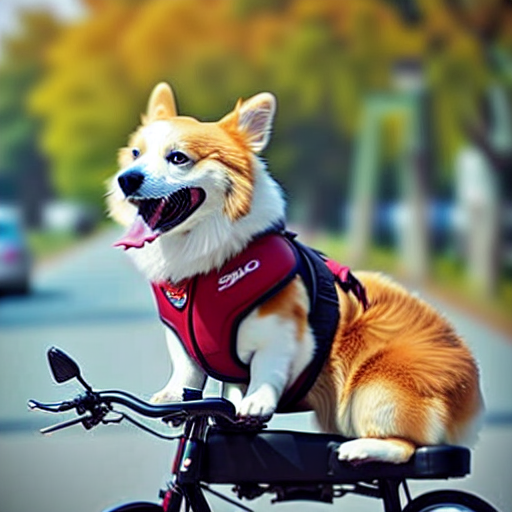

In [7]:
## Using the tuned prompt "sks dog" riding a bicycle

image = pipeline("A photo of sks dog riding bycycle", num_inference_steps=200, guidance_scale=7.5).images[0]
image.save("/scratch2/dog-bike.png")
image.show()

  0%|          | 0/200 [00:00<?, ?it/s]

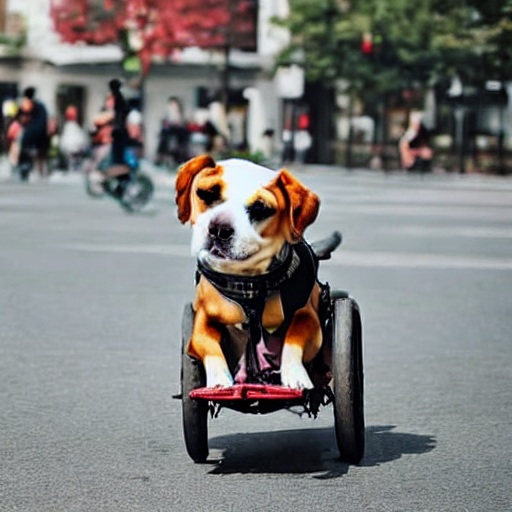

In [8]:
# different from without the prompt sks dog

image = pipeline("A photo of a dog riding bycycle", num_inference_steps=200, guidance_scale=7.5).images[0]
image.show()

  0%|          | 0/200 [00:00<?, ?it/s]

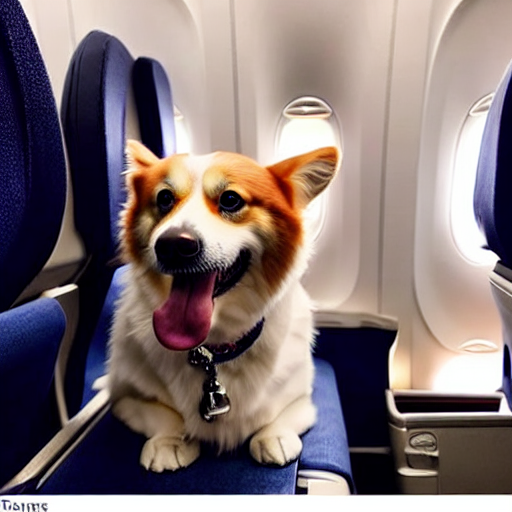

In [10]:
image = pipeline("A photo of sks dog on an airplane", num_inference_steps=200, guidance_scale=7.5).images[0]
image.show()

### Your tasks

In [4]:
#### Your Task ####
# Use your favourite character to build a DreamBooth model, and generate the character in at least three different scenes.  
# Note that if the model generates obviously wrong / non-sense images, you can leave them their, just to entertain the TAs!
MODEL_NAME="/share/lab5/sd"
INSTANCE_DIR="/root/lab1/lab5/data/sd_data" 
CLASS_DIR='/scratch3/original_footballplayer' 
MODEL_OUTPUT="/scratch3/footballplayer-model"

INSTANCE_PROMPT='a photo of ssi soccerplayer'
CLASS_PROMPT="a photo of a soccerplayer"

!python train_dreambooth.py \
  --pretrained_model_name_or_path={MODEL_NAME} \
  --instance_data_dir={INSTANCE_DIR} \
  --class_data_dir={CLASS_DIR} \
  --output_dir={MODEL_OUTPUT} \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="{INSTANCE_PROMPT}"\
  --class_prompt="{CLASS_PROMPT}" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --max_train_steps=800 \
  --gradient_checkpointing \
  --mixed_precision fp16

04/23/2024 10:33:15 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'sample_max_value', 'thresholding', 'prediction_type', 'rescale_betas_zero_snr', 'dynamic_thresholding_ratio', 'timestep_spacing', 'clip_sample_range', 'variance_type'} was not found in config. Values will be initialized to default values.
{'force_upcast', 'scaling_factor'} was not found in config. Values will be initialized to default values.
{'resnet_skip_time_act', 'time_embedding_act_fn', 'projection_class_embeddings_input_dim', 'conv_in_kernel', 'class_embed_type', 'conv_out_kernel', 'encoder_hid_dim_type', 'use_linear_projection', 'transformer_layers_per_block', 'time_cond_proj_dim', 'addition_embed_type', 'addition_embed_type_num_heads', 'addition_time_embed_di

In [5]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained(MODEL_OUTPUT, torch_dtype=torch.float16, use_safetensors=True).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

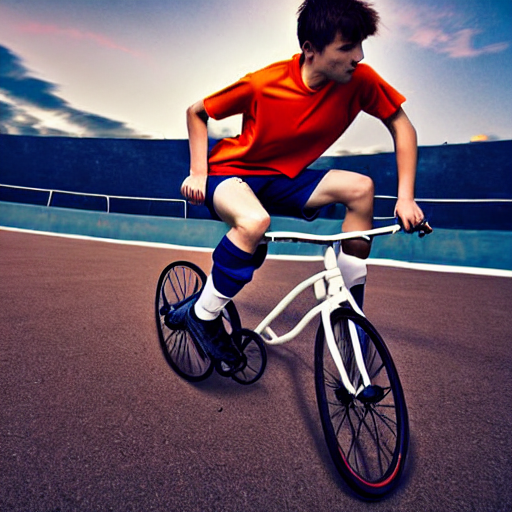

In [83]:
image = pipeline("A photo of ssi soccerplayer riding a bike, 4k, masterpiece, vivid colors, ray_tracing, the white race, best quality, best quality, intricate details, perfect body, full body, post processing, good saturation", num_inference_steps=200, guidance_scale=7.5).images[0]
image.save("/scratch3/footplayer-ridebike.png")
image.show()

  0%|          | 0/200 [00:00<?, ?it/s]

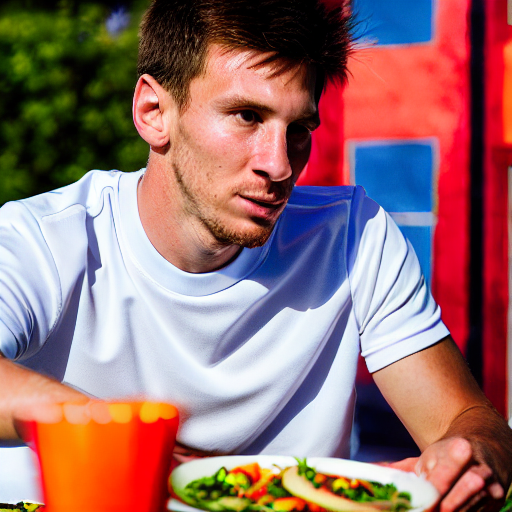

In [65]:
image = pipeline("A photo of ssi soccerplayer having dinner, 4k, masterpiece, vivid colors, ray_tracing, the white race, best quality, best quality, intricate details, perfect body, full body, post processing, good saturation", num_inference_steps=200, guidance_scale=7.5).images[0]
image.save("/scratch3/footplayer-dinner.png")
image.show()
#I don't know why this picture is of such high quality

  0%|          | 0/200 [00:00<?, ?it/s]

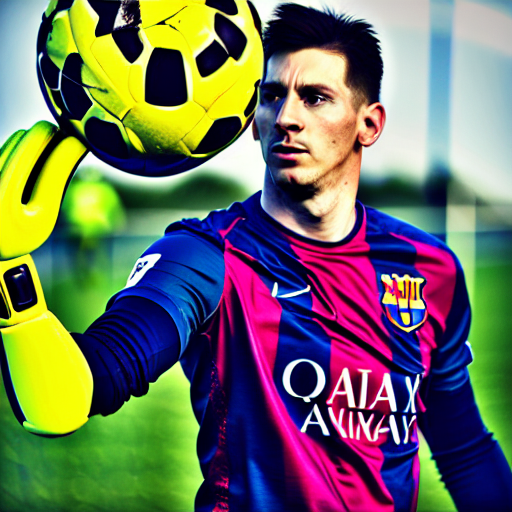

In [75]:
image = pipeline("A photo of ssi soccerplayer as a goalkeeper, 4k, masterpiece, vivid colors, ray_tracing, the white race, best quality, best quality, intricate details, perfect body, full body, post processing, good saturation", num_inference_steps=200, guidance_scale=7.5).images[0]
image.save("/scratch3/footplayer-goalkeeper.png")
image.show()